In [35]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Загрузка данных

In [36]:
data = pd.read_csv('../house/train.csv')
data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


# Добавим новые признаки

In [37]:
data['Age'] = data['YrSold'] - data['YearBuilt']
data['TotalAreaRatio'] = data['TotalBsmtSF'] / data['GrLivArea']

data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age,TotalAreaRatio
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,208500,5,0.500585
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2007,WD,Normal,181500,31,1.000000
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,9,2008,WD,Normal,223500,7,0.515118
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,91,0.440303
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,0,12,2008,WD,Normal,250000,8,0.520928
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,MnPrv,Shed,700,10,2009,WD,Normal,143000,16,0.584435
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,8,2007,WD,Normal,307000,3,0.995277
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,NaN,Shed,350,11,2009,WD,Normal,200000,36,0.529665
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,4,2008,WD,Abnorml,129900,77,0.536640
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,1,2008,WD,Normal,118000,69,0.920149


# Проверка на пропущенные значения

In [38]:
missing_values = data.isnull().sum()
print("Пропущенные значения в данных:")
print(missing_values[missing_values > 0])

Пропущенные значения в данных:
LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


# Разделение данных на признаки и целевую переменную

In [39]:
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение категориальных и числовых столбцов

In [40]:
categorical_columns = X_train.select_dtypes(include=['object']).columns
numeric_columns = X_train.select_dtypes(include=['number']).columns

# Создание pipeline для предобработки данных

In [41]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])


# Обьединение транформиров

In [42]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)


# Определение модели

In [43]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror'))
])

# Гиперпараметрический поиск

In [44]:
param_dist = {
    'regressor__n_estimators': [200],
    'regressor__max_depth': [4],
    'regressor__learning_rate': [0.05],
    'regressor__subsample': [0.6,],
    'regressor__colsample_bytree': [0.4,],
    'regressor__gamma': [0.2],
    'regressor__reg_alpha': [0.1],
    'regressor__reg_lambda': [1]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=4,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

Определяем лучшие параметры для модели

In [45]:
random_search.fit(X_train, y_train)

# Результат
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

Fitting 4 folds for each of 1 candidates, totalling 4 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found: {'regressor__subsample': 0.6, 'regressor__reg_lambda': 1, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 200, 'regressor__max_depth': 4, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0.2, 'regressor__colsample_bytree': 0.4}
Best score: -897766657.2718105


# Оценка модели

In [46]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mae)

print(f'MSE: {mae}')
print(f'RMSE: {rmse}')

MSE: 15688.358197773972
RMSE: 125.25317639794198


# Построение кривой обучения

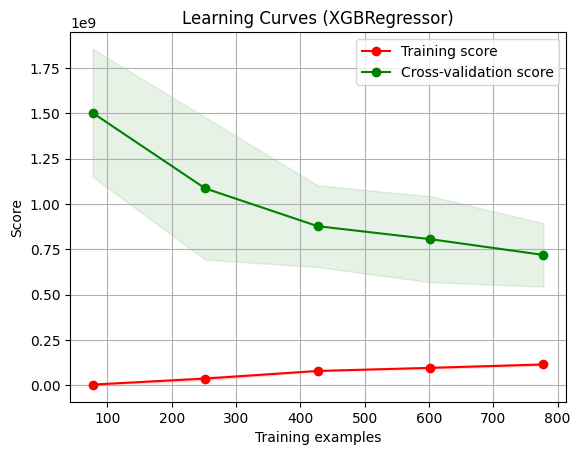

In [47]:
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    
    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

# Построение кривой обучения для лучшей модели
plot_learning_curve(best_model, "Learning Curves (XGBRegressor)", X_train, y_train, cv=3, n_jobs=-1)
plt.show()

# Сохранение модели

In [48]:
import pickle 
 
# Сохранение модели в файл 
with open('../models/xgb_model.pkl', 'wb') as file: 
    pickle.dump(best_model, file) 
 
# Загрузка модели из файла (для проверки) 
with open('../models/xgb_model.pkl', 'rb') as file: 
    loaded_model = pickle.load(file) 
 
# Проверка загруженной модели 
y_pred = loaded_model.predict(X_test) 
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))

Mean Absolute Error: 15688.358197773972


In [51]:
import mlflow
import mlflow.sklearn

# Configure MLflow
mlflow.set_tracking_uri("../House_price_try/mlruns")
mlflow.set_experiment("HousePricePrediction")


with mlflow.start_run() as run:
    # Log parameters and metrics
    mlflow.log_params(random_search.best_params_)
    mlflow.log_metric("mae", mean_absolute_error(y_test, y_pred))
    mlflow.log_metric("rmse", np.sqrt(mean_squared_error(y_test, y_pred)))

    # Log the model
    mlflow.sklearn.log_model(best_model, "xgb_regressor_model")

    # Get the current run ID
    run_id = run.info.run_id
    print("Run ID:", run_id)

# Загрузка модели из MLflow
logged_model = f'runs:/{run_id}/xgb_regressor_model'
loaded_model = mlflow.sklearn.load_model(logged_model)

# Проверка загруженной модели
loaded_predictions = loaded_model.predict(X_test)
print("Loaded model predictions:", loaded_predictions[:5]) 

2024/08/01 15:40:37 INFO mlflow.tracking.fluent: Experiment with name 'HousePricePrediction' does not exist. Creating a new experiment.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/08/01 15:40:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model 

Run ID: 46515af3ccb3488095046bb53662b82d
Loaded model predictions: [141492.2  330324.2  121353.16 150054.78 328887.25]
